<a href="https://colab.research.google.com/github/d-roland/toxicityDetection/blob/main/CS224n_Toxicity_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from tqdm import tqdm, trange
from collections import Counter, defaultdict
from wordcloud import WordCloud
import string
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from datetime import datetime
from statistics import mean
import random
import datetime
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:

from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

### Loading and merging datasets

In [4]:
colnames=['Sentence', 'Type', 'Level', 'Target'] 
hateful = pd.read_csv('/content/drive/My Drive/CS224n_Project/Hatefuls.csv', names=colnames, header=None)
hateful.shape

(194593, 4)

In [5]:
hateful.describe()

,Sentence,Type,Level,Target
count,194572,194593,194593,194593
unique,63324,14,4,6
top,tg,Insult,VERY_HIGH,USER
freq,1364,116947,66901,96997


In [6]:
#Adding a class column prior to merging with neutral data
hateful["Class"] = 1
hateful.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [7]:
hateful.Sentence = hateful.Sentence.astype(str)

In [8]:
neutral = pd.read_csv('/content/drive/My Drive/CS224n_Project/Neutrals_200k.csv', names=colnames, header=None)
neutral.shape

(200000, 4)

In [9]:
neutral.Sentence = neutral.Sentence.astype(str)

In [10]:
#Adding a class column prior to merging with toxic data
neutral["Class"] = 0
neutral.head()

,Sentence,Type,Level,Target,Class
0,"Chui désolé, mais quand un film de science-fic...",Neutral,NONE,UNDEFINED,0
1,Mdrrr junior bvndo,Neutral,NONE,UNDEFINED,0
2,baham je taimz,Neutral,NONE,UNDEFINED,0
3,Meilleurs rappeurs de tout les temps 😂😂😂 je ri...,Neutral,NONE,UNDEFINED,0
4,7up❤️,Neutral,NONE,UNDEFINED,0


In [11]:
dataset = hateful.append([neutral], ignore_index=True)
dataset.shape

(394593, 5)

In [12]:
dataset.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [13]:
dataset.tail()

,Sentence,Type,Level,Target,Class
394588,@studiosushi @Chitori_Bocchi evangelionnnnnnnn...,Neutral,NONE,UNDEFINED,0
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0
394592,Bah oui 80% de la police france est pro RN ...,Neutral,NONE,UNDEFINED,0


### Analyzing dataset

In [14]:
dataset.groupby(['Target']).count()

,Sentence,Type,Level,Class
Target,,,,
AUTHOR_OF_COMMENT,2547,2547,2547,2547
EVERYONE,16603,16603,16603,16603
GROUP,36083,36083,36083,36083
NO_ONE,1,1,1,1
SINGLE_PERSON,36128,36128,36128,36128
UNDEFINED,199191,199191,199191,199191
USER,97574,97574,97574,97574
USER_FAMILY,6466,6466,6466,6466


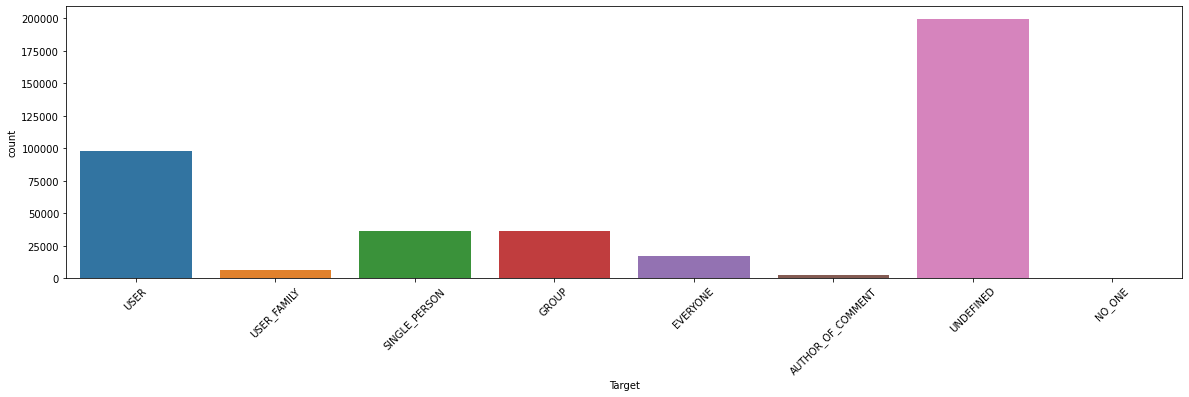

In [15]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Target", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [16]:
dataset.groupby(['Type']).count()

,Sentence,Level,Target,Class
Type,,,,
Ads,27,27,27,27
Critics,15,15,15,15
Hate,37293,37293,37293,37293
Homophobia,12256,12256,12256,12256
Insult,116947,116947,116947,116947
Misogyny,6,6,6,6
Mockery,13950,13950,13950,13950
Moral Harassment,1583,1583,1583,1583
Neutral,200009,200009,200009,200009


In [17]:
dataset.groupby(['Level']).count()

,Sentence,Type,Target,Class
Level,,,,
HIGH,53358,53358,53358,53358
LOW,28016,28016,28016,28016
MEDIUM,46880,46880,46880,46880
NONE,199189,199189,199189,199189
VERY_HIGH,67150,67150,67150,67150


In [18]:
dataset_stats = dataset.groupby(['Target', 'Level']).size().reset_index(name='count')
pd.pivot_table(dataset_stats, index=['Level'], columns = ['Target'],values=['count'], fill_value=0)

count                 ...                             
Target    AUTHOR_OF_COMMENT EVERYONE GROUP  ... UNDEFINED   USER USER_FAMILY
Level                                       ...                             
HIGH                    189     3952  9004  ...         4  27624        3577
LOW                    1350     2743  9031  ...         1   5481         378
MEDIUM                  837     2125  9036  ...        14  24422        1413
NONE                      0        4     0  ...    199171     13           0
VERY_HIGH               171     7779  9012  ...         1  40034        1098

[5 rows x 8 columns]

In [19]:
#Checking if empty Sentences exist
empty_index = [index for index,text in enumerate(dataset.Sentence.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_index)))
hateful.iloc[empty_index].tail()

No of empty rows: 0


,Sentence,Type,Level,Target,Class


In [20]:
#Removing row with "NO_ONE" target
dataset[dataset['Target']=="NO_ONE"]
dataset = dataset.drop(dataset[dataset['Target']=="NO_ONE"].index)

In [21]:
#Checking frequent words
cnt = Counter()
for text in dataset["Sentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 212725),
 ('la', 117592),
 ('et', 104727),
 ('le', 99444),
 ('les', 94956),
 ('pas', 85171),
 ('que', 81618),
 ('des', 72993),
 ('à', 66654),
 ('un', 63619),
 ('a', 58883),
 ('je', 58172),
 ('pour', 57210),
 ('en', 56610),
 ('qui', 55488),
 ('est', 54054),
 ('tu', 51424),
 ('vous', 42380),
 ('une', 41758),
 ('il', 39910)]

In [22]:
#Checking average sentence length vs toxicity level
dataset['Length'] = dataset['Sentence'].apply(len)
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Length',data = dataset,palette='PRGn',ax=ax1).set_title('Avg Sentence Length vs Level')
#sns.barplot('Target','Length',data = dataset,palette='PRGn',ax=ax2).set_title('Avg Sentence Length vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

In [23]:
#Checking average word number vs toxicity level
dataset['Count'] = dataset['Sentence'].str.split().str.len()
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Count',data = dataset,palette='PRGn',ax=ax1).set_title('Average Word Count vs Level')
#sns.barplot('Target','Count',data = dataset,palette='PRGn',ax=ax2).set_title('Average Word Count vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

### Cleaning dataset

In [24]:
#Lowering all sentences

dataset['cleanSentence'] = dataset['Sentence'].apply(lambda x: x.lower())
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo 😂😂🥃
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain 😂😂😂😂😂😂
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul


In [25]:
#Dealing with emojis
!pip install emoji
import emoji

#does the text contain an emoji?
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI["en"]:
            return True
    return False

#extract emojis for possible future use
def extract_emoji(text):
    emoji_list = []
    data = re.findall(r'[^\w\s,]', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
            emoji_list.append(word)
    return emoji_list

#remove the emoji
def remove_emoji(text):
  data = re.findall(r'[^\w\s,]', text)
  for word in data:
      if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
          text = text.replace(word, '')
  return text

# Checking if emoji in source Sentence
dataset['Emoji'] = dataset['Sentence'].apply(extract_emoji)

# Removing Emojis from Sentence
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_emoji)
dataset.head(10)

     |████████████████████████████████| 133kB 19.6MB/s 


,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c'est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,@vittoremorgane @crdsar et ? il est au dessus ...,[]


In [26]:
#Extracting list of unique emojis
import itertools
emoji_list = np.unique([*itertools.chain.from_iterable(dataset.Emoji)])
print(emoji_list[:30])

['©' '®' '‼' '⁉' '™' '↔' '↖' '↗' '↘' '↙' '↩' '↪' '⌛' '⌨' '⏩' '⏫' '⏬' '⏭'
 '⏰' '⏱' '⏳' '⏸' 'Ⓜ' '▪' '▶' '◀' '◼' '◽' '☀' '☁']


In [27]:
emoji_fr_dict = pd.read_csv('/content/drive/My Drive/CS224n_Project/emoji_fr_dict_int.csv', index_col=0, squeeze=True).to_dict()
list(emoji_fr_dict.items())[:10]

[(128512, 'visage souriant'),
 (128515, 'visage souriant avec de grands yeux'),
 (128516, 'visage souriant avec des yeux souriants'),
 (128513, 'visage rayonnant aux yeux souriants'),
 (128518, 'visage souriant plissant les yeux'),
 (128517, 'visage souriant de sueur'),
 (129315, 'roulant sur le sol en riant'),
 (128514, 'visage avec des larmes de joie'),
 (128578, 'visage légèrement souriant'),
 (128579, 'visage à l&#39;envers')]

In [28]:
#Convert emojis to corresponding text (to keep their spirit)
def convert_emojis(text):
    for emot in text:
      for subcode in emoji_fr_dict.keys():
        if emot == chr(subcode):
          text = [e.replace(emot, emoji_fr_dict[subcode]) for e in text]
    return text

dataset['EmojiToText'] = dataset['Emoji'].apply(convert_emojis)
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[visage avec des larmes de joie, visage avec d..."
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[visage avec des larmes de joie, visage avec d..."
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...,[],[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],[]


In [29]:
dataset.EmojiToText[0]

['visage avec des larmes de joie',
 'visage avec des larmes de joie',
 'verre de verre']

In [30]:
#Special characters cleaning
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove @

"""

def remove_special(text):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^ \nA-Za-z0-9À-ÖØ-öø-ÿ/ \t])", " ",text).split())
#    return " ".join(re.sub("(@[^\s]+)", " ",text).split())


#dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_nums)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_URL)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_html)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_special)

dataset['EmojiToText'] = dataset['EmojiToText'].apply(', '.join)
dataset['EmojiToText'] = dataset['EmojiToText'].apply(remove_special)

dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],


In [31]:
#Removing punctuation
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_punctuations)
dataset['EmojiToText'] = dataset['EmojiToText'].apply(remove_punctuations)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],


In [32]:
#Checking frequent words
cnt = Counter()
for text in dataset["cleanSentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 219669),
 ('est', 133579),
 ('la', 130991),
 ('et', 120552),
 ('le', 113016),
 ('les', 106419),
 ('c', 95209),
 ('pas', 92356),
 ('que', 84686),
 ('je', 80306),
 ('des', 77273),
 ('a', 76027),
 ('un', 75793),
 ('en', 73365),
 ('à', 70458),
 ('il', 67932),
 ('tu', 65680),
 ('pour', 61827),
 ('qui', 58492),
 ('l', 55957)]

In [33]:
dataset['enhancedSentence'] = dataset['cleanSentence'] + " " + dataset['EmojiToText']
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul


In [34]:
#Removing stopwords
STOPWORDS = nltk.corpus.stopwords.words('french')
#STOPWORDS = set(nltk.corpus.stopwords.words('english')) | set(nltk.corpus.stopwords.words('french'))

dataset_wo_stop = dataset.copy()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset_wo_stop['cleanSentence'] = dataset_wo_stop['cleanSentence'].apply(remove_stopwords)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[],,je te propose un d île je m abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[],,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[],,moi mdr t trop nul
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[],,c est quoi cette mode ou presque tout les yout...
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[],,et il est au dessus des lois je fais des reuni...


In [35]:
#Word Cloud on toxic posts by toxicity level
"""
text = ''
dataset_vh = pd.DataFrame()
dataset_vh = dataset_wo_stop[dataset_wo_stop['Level']=='VERY_HIGH']
for news in dataset_vh.cleanSentence.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del dataset_vh, text
"""

'\ntext = \'\'\ndataset_vh = pd.DataFrame()\ndataset_vh = dataset_wo_stop[dataset_wo_stop[\'Level\']==\'VERY_HIGH\']\nfor news in dataset_vh.cleanSentence.values:\n    text += news\nwordcloud = WordCloud(\n    width = 3000,\n    height = 2000,\n    background_color = \'white\',\n    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)\nfig = plt.figure(\n    figsize = (40, 30),\n    facecolor = \'k\',\n    edgecolor = \'k\')\nplt.imshow(wordcloud, interpolation = \'bilinear\')\nplt.axis(\'off\')\nplt.show()\ndel dataset_vh, text\n'

In [36]:
#Removing frequent words
#FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
FREQWORDS = ['de', 'est', 'la', 'et', 'le','les','c','que','des','a','un','en','à', 'pour','qui', 'l', 'd', 'une', 'ce', 'mais', 'qu', 'ne', 'ça', 'dans','du', 'sur', 'avec', 'tout', 'au', 'si', 'comme']

dataset_wo_freq = dataset.copy()

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

dataset_wo_freq['cleanSentence'] = dataset_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_wo_freq.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose île je m abonne ta chaine tu t a...,[],,je te propose un d île je m abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t kiko mdr,[],,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode ou presque youtubeurs joue jeu...,[],,c est quoi cette mode ou presque tout les yout...
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,il dessus lois je fais reunions travail tous j...,[],,et il est au dessus des lois je fais des reuni...


In [37]:
#Checking frequent words
cnt_frq = Counter()
for text in dataset_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_frq[word] += 1
        
cnt_frq.most_common(20)

[('pas', 92356),
 ('je', 80306),
 ('il', 67932),
 ('tu', 65680),
 ('vous', 53252),
 ('on', 44948),
 ('j', 42214),
 ('t', 33397),
 ('ta', 29548),
 ('n', 28819),
 ('plus', 28111),
 ('fait', 26564),
 ('faire', 26072),
 ('ai', 24814),
 ('se', 24618),
 ('merde', 22899),
 ('ou', 21633),
 ('bien', 21143),
 ('y', 20733),
 ('sont', 20577)]

### Tokenizing

In [38]:
dataset['finalSentence'] = dataset['cleanSentence'].apply(word_tokenize)
#dataset['finalSentence'] = dataset['enhancedSentence'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, un, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, de, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],,c est quoi cette mode ou presque tout les yout...,"[c, est, quoi, cette, mode, ou, presque, tout,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],,et il est au dessus des lois je fais des reuni...,"[et, il, est, au, dessus, des, lois, je, fais,..."


In [39]:
dataset['ultimateSentence'] = dataset['enhancedSentence'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]","[t, pas, bo, visage, avec, des, larmes, de, jo..."
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]","[t, es, vilain, visage, avec, des, larmes, de,..."
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à...","[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]","[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]","[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, un, mono, sourcils]","[ta, un, mono, sourcils, visage, avec, des, la..."
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]","[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, de, gamin]","[espèce, de, gamin, visage, avec, des, larmes,..."
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],,c est quoi cette mode ou presque tout les yout...,"[c, est, quoi, cette, mode, ou, presque, tout,...","[c, est, quoi, cette, mode, ou, presque, tout,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],,et il est au dessus des lois je fais des reuni...,"[et, il, est, au, dessus, des, lois, je, fais,...","[et, il, est, au, dessus, des, lois, je, fais,..."


In [40]:
dataset_wo_stop['finalSentence'] = dataset_wo_stop['cleanSentence'].apply(word_tokenize)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,[bo]
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,[vilain]
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[],,je te propose un d île je m abonne à ta chaine...,"[propose, île, abonne, chaine, abonner, chaîne..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[],,t un kiko mdr,"[kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[],,moi mdr t trop nul,"[mdr, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[],,c est quoi cette mode ou presque tout les yout...,"[quoi, cette, mode, presque, tout, youtubeurs,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[],,et il est au dessus des lois je fais des reuni...,"[dessus, lois, fais, reunions, travail, tous, ..."


In [41]:
dataset_wo_freq['finalSentence'] = dataset_wo_freq['cleanSentence'].apply(word_tokenize)
dataset_wo_freq.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose île je m abonne ta chaine tu t a...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, île, je, m, abonne, ta, chai..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t kiko mdr,[],,t un kiko mdr,"[t, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode ou presque youtubeurs joue jeu...,[],,c est quoi cette mode ou presque tout les yout...,"[quoi, cette, mode, ou, presque, youtubeurs, j..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,il dessus lois je fais reunions travail tous j...,[],,et il est au dessus des lois je fais des reuni...,"[il, dessus, lois, je, fais, reunions, travail..."


In [ ]:
dataset['Emoji_token'] = dataset['EmojiToText']
dataset['Emoji_token'] = dataset['Emoji_token'].apply(remove_special)
dataset['Emoji_token'] = dataset['Emoji_token'].apply(remove_punctuations)
dataset['Emoji_token'] = dataset['Emoji_token'].apply(word_tokenize)
dataset.head(10)

In [ ]:
#Alternative: Keeping only 60k neutral examples for a more balanced dataset

remove_n = len(dataset[dataset.Class == 0]) - 60000
neutralIndices = dataset[dataset.Class == 0].index
drop_indices = np.random.choice(neutralIndices, remove_n)
short_dataset = dataset.drop(index = drop_indices)
short_dataset

In [ ]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Level", data=short_dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
simpleDataset = short_dataset[['cleanSentence', 'Level']].copy()
simpleDataset.head()

In [ ]:
simpleTrain, simpleTest = train_test_split(simpleDataset, test_size=0.2)
print(simpleTrain.shape, simpleTest.shape)

### Data augmentation (Google Translate)

In [47]:
dataset_low = dataset[dataset["Level"] == "LOW"]
dataset_low.reset_index(inplace=True)
        
dataset_medium = dataset[dataset["Level"] == "MEDIUM"]  
dataset_medium.reset_index(inplace=True)

dataset_high = dataset[dataset["Level"] == "HIGH"]
dataset_high.reset_index(inplace=True)

dataset_veryhigh = dataset[dataset["Level"] == "VERY_HIGH"]
dataset_veryhigh.reset_index(inplace=True)

In [48]:
low = []
with open('/content/drive/My Drive/CS224n_Project/Translated_low.txt') as f:
    for line in f:
        if line.strip() == "":
          line = " " 
        low.append(line.strip())

dataset_low["Retranscript"] = low
dataset_low

,index,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token,Retranscript
0,587,Mdr le pointeur 😂,Insult,MEDIUM,USER,1,17,4,mdr le pointeur,[😂],visage avec des larmes de joie,mdr le pointeur visage avec des larmes de joie,"[mdr, le, pointeur]","[mdr, le, pointeur, visage, avec, des, larmes,...","[visage, avec, des, larmes, de, joie]",mdr le pointeur
1,588,C'est toi qui a gagné pour moi celle de pixia ...,Hate,MEDIUM,USER,1,57,13,c est toi qui a gagné pour moi celle de pixia ...,[],,c est toi qui a gagné pour moi celle de pixia ...,"[c, est, toi, qui, a, gagné, pour, moi, celle,...","[c, est, toi, qui, a, gagné, pour, moi, celle,...",[],c&#39;est toi qui as gagné pour moi celui de p...
2,589,Nuuulll,Hate,MEDIUM,USER,1,7,1,nuuulll,[],,nuuulll,[nuuulll],[nuuulll],[],nuuulll
3,590,T est nulle depuis des années ta le même nombr...,Hate,MEDIUM,USER,1,59,13,t est nulle depuis des années ta le même nombr...,[],,t est nulle depuis des années ta le même nombr...,"[t, est, nulle, depuis, des, années, ta, le, m...","[t, est, nulle, depuis, des, années, ta, le, m...",[],t est nul depuis des années vous avez le même ...
4,591,ouais ouais tes nul slash kun,Hate,MEDIUM,USER,1,29,6,ouais ouais tes nul slash kun,[],,ouais ouais tes nul slash kun,"[ouais, ouais, tes, nul, slash, kun]","[ouais, ouais, tes, nul, slash, kun]",[],ouais ouais tu suce slash kun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46874,386272,@Le___Doc Pas un mot pour nos grosses tronches...,Neutral,MEDIUM,USER,0,164,29,doc pas un mot pour nos grosses tronches de bl...,[],,doc pas un mot pour nos grosses tronches de bl...,"[doc, pas, un, mot, pour, nos, grosses, tronch...","[doc, pas, un, mot, pour, nos, grosses, tronch...",[],doc pas un mot pour nos gros visages en blouse...
46875,387150,C'est ça la justice en France 🇫🇷 chacun y fait...,Neutral,MEDIUM,USER,0,150,30,c est ça la justice en france chacun y fait y ...,[],,c est ça la justice en france chacun y fait y ...,"[c, est, ça, la, justice, en, france, chacun, ...","[c, est, ça, la, justice, en, france, chacun, ...",[],c&#39;est la justice en France tout le monde f...
46876,392577,@nadine__morano T'es qui pour décider ça ?,Neutral,MEDIUM,USER,0,42,7,morano t es qui pour décider ça,[],,morano t es qui pour décider ça,"[morano, t, es, qui, pour, décider, ça]","[morano, t, es, qui, pour, décider, ça]",[],qui es-tu pour en décider
46877,392988,"On en est là... un eugénisme assumé, tant pis ...",Neutral,MEDIUM,USER,0,274,47,on en est là un eugénisme assumé tant pis pour...,[],,on en est là un eugénisme assumé tant pis pour...,"[on, en, est, là, un, eugénisme, assumé, tant,...","[on, en, est, là, un, eugénisme, assumé, tant,...",[],c&#39;est le cas de l&#39;eugénisme présumé ta...


In [49]:
dataset_low['Retranscript'] = dataset_low['Retranscript'].map(lambda x: re.sub(r'\W\W39\;', ' ', x))
dataset_low

,index,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token,Retranscript
0,587,Mdr le pointeur 😂,Insult,MEDIUM,USER,1,17,4,mdr le pointeur,[😂],visage avec des larmes de joie,mdr le pointeur visage avec des larmes de joie,"[mdr, le, pointeur]","[mdr, le, pointeur, visage, avec, des, larmes,...","[visage, avec, des, larmes, de, joie]",mdr le pointeur
1,588,C'est toi qui a gagné pour moi celle de pixia ...,Hate,MEDIUM,USER,1,57,13,c est toi qui a gagné pour moi celle de pixia ...,[],,c est toi qui a gagné pour moi celle de pixia ...,"[c, est, toi, qui, a, gagné, pour, moi, celle,...","[c, est, toi, qui, a, gagné, pour, moi, celle,...",[],c est toi qui as gagné pour moi celui de pixia...
2,589,Nuuulll,Hate,MEDIUM,USER,1,7,1,nuuulll,[],,nuuulll,[nuuulll],[nuuulll],[],nuuulll
3,590,T est nulle depuis des années ta le même nombr...,Hate,MEDIUM,USER,1,59,13,t est nulle depuis des années ta le même nombr...,[],,t est nulle depuis des années ta le même nombr...,"[t, est, nulle, depuis, des, années, ta, le, m...","[t, est, nulle, depuis, des, années, ta, le, m...",[],t est nul depuis des années vous avez le même ...
4,591,ouais ouais tes nul slash kun,Hate,MEDIUM,USER,1,29,6,ouais ouais tes nul slash kun,[],,ouais ouais tes nul slash kun,"[ouais, ouais, tes, nul, slash, kun]","[ouais, ouais, tes, nul, slash, kun]",[],ouais ouais tu suce slash kun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46874,386272,@Le___Doc Pas un mot pour nos grosses tronches...,Neutral,MEDIUM,USER,0,164,29,doc pas un mot pour nos grosses tronches de bl...,[],,doc pas un mot pour nos grosses tronches de bl...,"[doc, pas, un, mot, pour, nos, grosses, tronch...","[doc, pas, un, mot, pour, nos, grosses, tronch...",[],doc pas un mot pour nos gros visages en blouse...
46875,387150,C'est ça la justice en France 🇫🇷 chacun y fait...,Neutral,MEDIUM,USER,0,150,30,c est ça la justice en france chacun y fait y ...,[],,c est ça la justice en france chacun y fait y ...,"[c, est, ça, la, justice, en, france, chacun, ...","[c, est, ça, la, justice, en, france, chacun, ...",[],c est la justice en France tout le monde fait ...
46876,392577,@nadine__morano T'es qui pour décider ça ?,Neutral,MEDIUM,USER,0,42,7,morano t es qui pour décider ça,[],,morano t es qui pour décider ça,"[morano, t, es, qui, pour, décider, ça]","[morano, t, es, qui, pour, décider, ça]",[],qui es-tu pour en décider
46877,392988,"On en est là... un eugénisme assumé, tant pis ...",Neutral,MEDIUM,USER,0,274,47,on en est là un eugénisme assumé tant pis pour...,[],,on en est là un eugénisme assumé tant pis pour...,"[on, en, est, là, un, eugénisme, assumé, tant,...","[on, en, est, là, un, eugénisme, assumé, tant,...",[],c est le cas de l eugénisme présumé tant pis p...


In [50]:
dataset_low['Retranscript_tok'] = dataset_low['Retranscript'].apply(word_tokenize)
dataset_low.head(10)

,index,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token,Retranscript,Retranscript_tok
0,587,Mdr le pointeur 😂,Insult,MEDIUM,USER,1,17,4,mdr le pointeur,[😂],visage avec des larmes de joie,mdr le pointeur visage avec des larmes de joie,"[mdr, le, pointeur]","[mdr, le, pointeur, visage, avec, des, larmes,...","[visage, avec, des, larmes, de, joie]",mdr le pointeur,"[mdr, le, pointeur]"
1,588,C'est toi qui a gagné pour moi celle de pixia ...,Hate,MEDIUM,USER,1,57,13,c est toi qui a gagné pour moi celle de pixia ...,[],,c est toi qui a gagné pour moi celle de pixia ...,"[c, est, toi, qui, a, gagné, pour, moi, celle,...","[c, est, toi, qui, a, gagné, pour, moi, celle,...",[],c est toi qui as gagné pour moi celui de pixia...,"[c, est, toi, qui, as, gagné, pour, moi, celui..."
2,589,Nuuulll,Hate,MEDIUM,USER,1,7,1,nuuulll,[],,nuuulll,[nuuulll],[nuuulll],[],nuuulll,[nuuulll]
3,590,T est nulle depuis des années ta le même nombr...,Hate,MEDIUM,USER,1,59,13,t est nulle depuis des années ta le même nombr...,[],,t est nulle depuis des années ta le même nombr...,"[t, est, nulle, depuis, des, années, ta, le, m...","[t, est, nulle, depuis, des, années, ta, le, m...",[],t est nul depuis des années vous avez le même ...,"[t, est, nul, depuis, des, années, vous, avez,..."
4,591,ouais ouais tes nul slash kun,Hate,MEDIUM,USER,1,29,6,ouais ouais tes nul slash kun,[],,ouais ouais tes nul slash kun,"[ouais, ouais, tes, nul, slash, kun]","[ouais, ouais, tes, nul, slash, kun]",[],ouais ouais tu suce slash kun,"[ouais, ouais, tu, suce, slash, kun]"
5,592,Nul nul nul,Hate,MEDIUM,USER,1,11,3,nul nul nul,[],,nul nul nul,"[nul, nul, nul]","[nul, nul, nul]",[],non non Non Non,"[non, non, Non, Non]"
6,593,Nule,Hate,MEDIUM,USER,1,4,1,nule,[],,nule,[nule],[nule],[],zéro,[zéro]
7,594,Nul,Hate,MEDIUM,USER,1,3,1,nul,[],,nul,[nul],[nul],[],non,[non]
8,595,te nule,Hate,MEDIUM,USER,1,8,2,te nule,[],,te nule,"[te, nule]","[te, nule]",[],nule toi,"[nule, toi]"
9,596,"Wazz tu me déçois, tu commences toi aussi à pr...",Mockery,MEDIUM,USER,1,234,42,wazz tu me déçois tu commences toi aussi à pre...,[],,wazz tu me déçois tu commences toi aussi à pre...,"[wazz, tu, me, déçois, tu, commences, toi, aus...","[wazz, tu, me, déçois, tu, commences, toi, aus...",[],wazz tu me déçois tu commences aussi à prendre...,"[wazz, tu, me, déçois, tu, commences, aussi, à..."


In [ ]:
from sentence_transformers import SentenceTransformer, util
sent_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

sentences = dataset_low['Retranscript'].tolist()
sent_embeddings = sent_model.encode(sentences, convert_to_tensor=True)
dataset_low['Embed_retrans'] = sent_embeddings

dataset_low.head()

In [ ]:
ref_sentences = dataset_low['cleanSentence'].tolist()
clean_embeddings = sent_model.encode(ref_sentences, convert_to_tensor=True)
dataset_low['Embed_clean'] = clean_embeddings

dataset_low.head()

In [ ]:
dataset_low['Similarity_score'] = dataset_low[[dataset_medium['Embed_retrans'], dataset_low['Embed_clean']]].apply(lambda x: util.pytorch_cos_sim(x)

### Creating final datasets

In [51]:
final_dataset = dataset_wo_freq.copy()

#### Keras tokenization of Sentences

In [52]:
#Tokenizing Text with Keras -> Representing each word by a number
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(final_dataset["finalSentence"])

X_tok = tokenizer.texts_to_sequences(final_dataset["finalSentence"])


In [53]:
X_tok[0][:10]

[8, 1, 5492]

In [54]:
#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

pas -> 1
je -> 2
il -> 3
tu -> 4
vous -> 5
on -> 6
j -> 7
t -> 8
ta -> 9
n -> 10


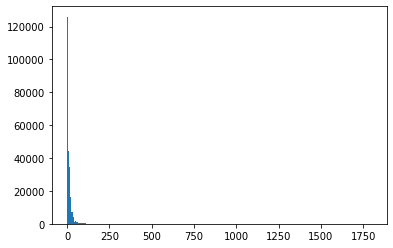

In [55]:
# Making histogram for no of words in sentences shows that most news sentences are under 150 words.
plt.hist([len(x) for x in X_tok], bins=500)
plt.show()

In [56]:
#Lets keep all sentences to 150, add padding to news with less than 150 words and truncating long ones
maxlen = 150 

#Making all news of size maxlen defined above, padding with 0 when needed
X_tok = pad_sequences(X_tok, maxlen=maxlen)

In [57]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

#### One-Hot vectors of Levels

In [58]:
#Encoding labels as one-hot vectors
y = final_dataset["Level"]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print(y)

0          LOW
1          LOW
2          LOW
3          LOW
4          LOW
          ... 
394588    NONE
394589    NONE
394590    NONE
394591    NONE
394592    NONE
Name: Level, Length: 394592, dtype: object


In [59]:
labels_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
labels_mapping

{'HIGH': 0, 'LOW': 1, 'MEDIUM': 2, 'NONE': 3, 'VERY_HIGH': 4}

In [60]:
# convert integers to dummy variables (i.e. one hot encoded)
onehot_y = np_utils.to_categorical(encoded_y)

#### One-Hot vectors of Targets

In [61]:
#Encoding targets as one-hot vectors
targets = final_dataset["Target"]
encoder = LabelEncoder()
encoder.fit(targets)
encoded_targets = encoder.transform(targets)
print(targets)

0              USER
1              USER
2              USER
3              USER
4              USER
            ...    
394588    UNDEFINED
394589    UNDEFINED
394590    UNDEFINED
394591    UNDEFINED
394592    UNDEFINED
Name: Target, Length: 394592, dtype: object


In [62]:
onehot_targets = np_utils.to_categorical(encoded_targets)
onehot_targets

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [63]:
targets_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
targets_mapping

{'AUTHOR_OF_COMMENT': 0,
 'EVERYONE': 1,
 'GROUP': 2,
 'SINGLE_PERSON': 3,
 'UNDEFINED': 4,
 'USER': 5,
 'USER_FAMILY': 6}

#### Keras tokenization of Emojis

In [65]:
"""#Tokenizing EmojisToText with Keras -> Representing each word by a number
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_emojis = Tokenizer(lower=True)
tokenizer_emojis.fit_on_texts(final_dataset["Emoji_token"])

E_tok = tokenizer_emojis.texts_to_sequences(final_dataset["Emoji_token"])


KeyError: ignored

In [ ]:
"""#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
emoji_index = tokenizer_emojis.word_index
for word, num in emoji_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

In [ ]:
"""print(np.average([len(x) for x in E_tok]))

In [ ]:
"""#Lets keep all emoji description to 50, add padding to short ones and truncating long ones
maxlen_emoji = 50

#Making all news of size maxlen defined above, padding with 0 when needed
E_tok = pad_sequences(E_tok, maxlen=maxlen_emoji)

In [ ]:
"""# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size increases by 1
emo_vocab_size = len(tokenizer_emojis.word_index) + 1

#### Dataset split

In [66]:
#Creating input and output sets
#X_train_tok, X_test_tok, E_train_tok, E_test_tok, X_train_targets, X_test_targets, y_train_tok, y_test_tok = train_test_split(X_tok, E_tok, onehot_targets, onehot_y, test_size = 0.2) 
X_train_tok, X_test_tok, X_train_targets, X_test_targets, y_train_tok, y_test_tok = train_test_split(X_tok, onehot_targets, onehot_y, test_size = 0.2) 

# Vectorization

In [67]:
EMBEDDING_DIM = 200

In [68]:
# Function to create weight matrix between word-index and vectors from gensim models
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try: 
          weight_matrix[i] = model[word]
        except:
          pass
    return weight_matrix

### Via Word2Vec

In [69]:
w2v_model = gensim.models.Word2Vec(sentences=final_dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [70]:
len(w2v_model.wv.vocab)

36574

In [71]:
w2v_model["merde"]

array([ 6.4497715e-01, -1.2158766e+00,  2.1553895e+00, -2.4261369e-01,
       -1.4798632e+00, -4.1722068e-01,  8.4625858e-01,  7.2809255e-01,
       -4.4248697e-01,  1.3488305e+00,  5.8351118e-02,  1.2622955e+00,
        1.8153417e+00, -3.4734151e-01, -2.4134135e-01, -1.3582945e+00,
       -2.3167291e+00, -1.3445981e+00, -2.2881472e+00, -6.4201123e-01,
        2.5381799e+00,  2.6599379e+00, -8.0338919e-01,  1.3942081e+00,
       -1.7751904e+00,  1.9210457e+00,  1.0591844e+00,  8.3641922e-01,
        7.2299761e-01, -6.2627935e-01,  1.5307586e+00,  5.1042873e-01,
       -3.1510153e+00, -6.6613936e-01, -1.1674989e+00,  3.2886333e+00,
        1.4491682e+00, -5.3227735e-01,  1.5745676e+00,  3.5831861e-03,
        2.3716171e+00, -1.2939495e+00, -9.0214139e-01,  9.4052815e-01,
        5.7748991e-01,  3.9382559e-01, -1.3100466e+00,  1.3476920e+00,
        5.0458908e-01,  7.2275054e-01, -2.8800738e-01, -1.2537146e-01,
       -9.7141922e-01, -5.9364766e-02,  8.7224662e-01, -8.1109077e-01,
      

In [72]:
print(w2v_model.wv.most_similar("merde"))

[('merdes', 0.5594661831855774), ('conneries', 0.4630226790904999), ('mrd', 0.39821183681488037), ('salopards', 0.374895840883255), ('m3rde', 0.3706732392311096), ('arnaque', 0.3669450879096985), ('darronnes', 0.36570003628730774), ('daube', 0.3549192547798157), ('faute', 0.35332077741622925), ('abrutis', 0.35212138295173645)]


In [73]:
w2v_embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
#w2v_emojis = gensim.models.Word2Vec(sentences=final_dataset["Emoji_token"], size=EMBEDDING_DIM, window=5, min_count=5)

In [ ]:
#len(w2v_emojis.wv.vocab)

834

In [ ]:
#w2v_emoji_embedding_vectors = get_weight_matrix(w2v_emojis, emoji_index)

### Via FastText (Gensim)

In [ ]:
fasttext_model = gensim.models.FastText(sentences=final_dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [ ]:
len(fasttext_model.wv.vocab)

36605

In [ ]:
fasttext_model.wv["merde"]

array([ 1.1284579 ,  0.6026093 ,  0.55194414, -1.4858775 , -1.8394794 ,
       -3.0810142 , -0.940217  , -1.6027595 , -1.5497886 , -0.85429865,
       -0.6348115 , -1.8178934 ,  2.1839948 , -1.6538231 , -0.85423   ,
       -1.5764794 ,  1.4149851 ,  1.0057323 , -0.36474034,  0.29080233,
       -0.21080719, -0.17950217, -0.45694226,  1.8594996 , -2.1465688 ,
        0.2735612 ,  0.3968396 , -0.62402505, -0.9700226 , -1.2724721 ,
        1.8486054 ,  0.15272905,  0.54489774, -0.37184393,  0.6777381 ,
        2.389091  , -0.8056522 ,  0.8209127 ,  0.25181684, -1.0788106 ,
        0.50884855, -1.0748245 , -1.5625927 ,  2.1265693 ,  0.769541  ,
        2.002416  ,  0.7465693 ,  0.2287906 ,  0.11381675,  0.21265097,
       -1.9339    , -0.12194537, -0.7238728 , -2.128207  , -1.4337852 ,
       -1.9397132 , -2.0834067 , -1.2747929 , -1.898521  ,  0.45629272,
       -1.0381802 ,  1.0910054 , -2.6330535 ,  1.1270115 ,  2.9112854 ,
       -0.17099997,  1.5804169 , -1.9675343 , -0.30740622, -3.94

In [ ]:
print(fasttext_model.wv.most_similar("merde"))

[('merdebfmmerde', 0.9710953235626221), ('dmerde', 0.9606221318244934), ('merdeee', 0.9603695273399353), ('bfmerde', 0.9471138715744019), ('merdeu', 0.9379007816314697), ('merdeeee', 0.9377528429031372), ('emerde', 0.9298129677772522), ('merddd', 0.9261928796768188), ('merd', 0.9223754405975342), ('démerde', 0.9182571172714233)]


In [ ]:
ft_embedding_vectors = get_weight_matrix(fasttext_model, word_index)

### Via FastText Pretrained vectors

In [ ]:
!pip install fasttext

#Recommended alternative, since few modules are missing in the PyPi package:
#!pip uninstall fasttext
#!git clone https://github.com/facebookresearch/fastText.git
#!cd fastText
#!pip install .

     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094870 sha256=382d9c3c620812490e28612c61ebea8939f9cf1af438a67b542e516239f1ff21
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
import fasttext.util
fasttext.util.download_model('fr', if_exists='ignore')
ft_pre_model = fasttext.load_model('cc.fr.300.bin')

In [ ]:
ft_pre_model.get_dimension()

300

In [ ]:
ft_pre_model.get_nearest_neighbors('merde')

NameError: ignored

In [ ]:
#Optional - reduce vectors dimensions
fasttext.util.reduce_model(ft_pre_model, 200)
ft_pre_model.get_dimension()

In [ ]:
ft_pre_embedding_vectors = get_weight_matrix(ft_pre_model, word_index)

# Modelization

## Baseline - Prediction based on sentence only

### Via Perspective API

In [ ]:
"""
from googleapiclient import discovery
import json

API_KEY=''

service = discovery.build('commentanalyzer', 'v1alpha1', developerKey=API_KEY)


Labels = []
Predictions = []
Language = []
Fail = []

file1 = open('dataset_clean.txt', 'r')
Lines = file1.readlines()

last_time = time.time()
count = 0

for line in Lines:
  time.sleep(1)        

  elements = line.split(" ", 1)

  analyze_request = {
                'comment': { 'text': elements[1].strip() },
                'requestedAttributes': {'TOXICITY': {}}
              }

  try:
      response = service.comments().analyze(body=analyze_request).execute()
  except Exception as e:
      Fail.append(elements[1])
      print(elements[1])
      continue    

  Labels.append(elements[0])
  Language.append(json.dumps(response["languages"][0], indent=2))
  proba = json.dumps(response["attributeScores"]["TOXICITY"]["spanScores"][0]["score"]["value"], indent=2)
  if float(proba) <= 0.2:
      Predictions.append("NONE")
  elif float(proba) <= 0.4:
      Predictions.append("LOW")
  elif float(proba) <= 0.6:
      Predictions.append("MEDIUM")
  elif float(proba) <= 0.8:
      Predictions.append("HIGH")
  else:
      Predictions.append("VERY_HIGH")
  count += 1


with open('/content/drive/My Drive/CS224n_Project/Perspective_labels.txt'', 'w') as f:
    for item in Labels:
        f.write("%s," % item)

with open('/content/drive/My Drive/CS224n_Project/Perspective_preds.txt'', 'w') as f:
    for item in Predictions:
        f.write("%s," % item)

In [4]:
#Analysis of Toxicity scores obtained from Perspective API on part of the dataset

perspective = pd.DataFrame()

with open('/content/drive/My Drive/CS224n_Project/Perspective_labels.txt') as f:
  label_values = f.readlines()
  label_levels = label_values[0].split(",")

with open('/content/drive/My Drive/CS224n_Project/Perspective_preds.txt') as f:
  pred_values = f.readlines()
  pred_levels = pred_values[0].split(",")

perspective["Labels"] = label_levels
perspective["Predictions"] = pred_levels

perspective["Result"] = (perspective['Labels']==perspective['Predictions']).astype(int)
perspective['Sentences'] = pd.read_csv('/content/drive/My Drive/CS224n_Project/Perspective_sent.txt', sep="\n", header=None)

perspective

,Labels,Predictions
0,LOW,NONE
1,LOW,LOW
2,LOW,NONE
3,LOW,NONE
4,LOW,MEDIUM
...,...,...
99995,MEDIUM,HIGH
99996,MEDIUM,MEDIUM
99997,MEDIUM,VERY_HIGH
99998,MEDIUM,HIGH


In [10]:
z = perspective["Labels"]
encoder = LabelEncoder()
encoder.fit(z)
encoded_z = encoder.transform(z)
perspective["Labels_num"] = encoded_z
perspective

,Labels,Predictions,Sentences,Result,Labels_num
0,LOW,NONE,t pas bo,0,1
1,LOW,LOW,t es vilain,1,1
2,LOW,NONE,je te propose un d île je m abonne à ta chaine...,0,1
3,LOW,NONE,t un kiko mdr,0,1
4,LOW,MEDIUM,moi mdr t trop nul,0,1
...,...,...,...,...,...
99995,MEDIUM,HIGH,et après on s étonne d en voir qui font les pu...,0,2
99996,MEDIUM,MEDIUM,on dirait une parodie de campagne de green was...,1,2
99997,MEDIUM,VERY_HIGH,damien renaud tous des salopes de a à z,0,2
99998,MEDIUM,HIGH,surtout une bande de c,0,2


In [11]:
labels_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
labels_mapping['NONE'] = 5
labels_mapping

{'HIGH': 0, 'LOW': 1, 'MEDIUM': 2, 'NONE': 5, 'VERY_HIGH': 3}

In [12]:
perspective['Predictions_num'] = perspective['Predictions'].apply(lambda x: labels_mapping[x])

In [13]:
print(classification_report(perspective["Labels_num"], perspective["Predictions_num"]))

              precision    recall  f1-score   support

           0       0.26      0.18      0.22     27175
           1       0.23      0.20      0.21     14816
           2       0.26      0.14      0.18     24005
           3       0.45      0.46      0.45     34004
           5       0.00      0.00      0.00         0

    accuracy                           0.27    100000
   macro avg       0.24      0.20      0.21    100000
weighted avg       0.32      0.27      0.29    100000



In [14]:
conf_matrix = confusion_matrix(perspective["Labels_num"], perspective["Predictions_num"])
print(conf_matrix)

[[ 5025  3325  3073 10955  4797]
 [ 3239  2919  2984  2177  3497]
 [ 5301  3510  3325  6173  5696]
 [ 5934  2768  3372 15530  6400]
 [    0     0     0     0     0]]


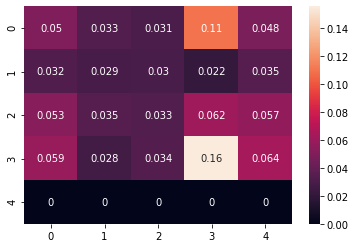

In [15]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [18]:
#Error analysis
perspective[perspective["Result"] == 0][:50]

,Labels,Predictions,Sentences,Result,Labels_num,Predictions_num
0,LOW,NONE,t pas bo,0,1,5
2,LOW,NONE,je te propose un d île je m abonne à ta chaine...,0,1,5
3,LOW,NONE,t un kiko mdr,0,1,5
4,LOW,MEDIUM,moi mdr t trop nul,0,1,2
6,LOW,VERY_HIGH,grosse merdes,0,1,3
7,LOW,MEDIUM,espèce de gamin,0,1,2
8,LOW,MEDIUM,c est quoi cette mode ou presque tout les yout...,0,1,2
9,LOW,HIGH,et il est au dessus des lois je fais des reuni...,0,1,0
10,LOW,NONE,vous êtes gênant,0,1,5
12,LOW,MEDIUM,frr c quoi sa car t radin je vais venir chez t...,0,1,2


### Via FastText

In [ ]:
import fasttext

In [ ]:
#Data preparation for fasttext format

X_train_ft, X_test_ft, y_train_fr, y_test_ft = train_test_split(dataset['cleanSentence'],  dataset['Level'], test_size = 0.2)

label_mapping = {'NONE': '__label__0',
                     'LOW': '__label__1',
                     'MEDIUM': '__label__2',
                     'HIGH': '__label__3',
                     'VERY_HIGH': '__label__4'}

with open('fasttext_train.txt', 'w') as f:
    for each_text, each_label in zip(X_train_ft, y_train_fr):
        each_label = label_mapping[each_label]
        f.writelines(f'{each_label} {each_text}\n')

with open('fasttext_test.txt', 'w') as f:
    for each_text, each_label in zip(X_test_ft, y_test_ft):
        each_label = label_mapping[each_label]
        f.writelines(f'{each_label} {each_text}\n')

In [ ]:
#Training
ft_model2 = fasttext.train_supervised('fasttext_train.txt')

#model = fasttext.train_supervised(input=train_fn,
#                                  pretrainedVectors=pretrainedvec_fn,
#                                  dim=200, 
#                                  wordNgrams=2, 
#                                  minCount=3, 
#                                  epoch=20, 
#                                  loss='ova')

In [ ]:
#print(ft_model2.words)
print(ft_model2.labels)

In [ ]:
#Evaluation
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*ft_model2.test('fasttext_test.txt'))

### Via Bi-LSTM

In [ ]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
#lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          26505600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1005      
Total params: 26,894,901
Trainable params: 389,301
Non-trainable params: 26,505,600
_________________________________________________________________


In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, y_train_tok, validation_split=0.2, epochs=10, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/10
494/494 [==============================] - 542s 1s/step - loss: 0.8064 - acc: 0.7124 - val_loss: 0.6712 - val_acc: 0.7609
Epoch 2/10
494/494 [==============================] - 538s 1s/step - loss: 0.6329 - acc: 0.7770 - val_loss: 0.5791 - val_acc: 0.7979
Epoch 3/10
494/494 [==============================] - 547s 1s/step - loss: 0.5584 - acc: 0.8053 - val_loss: 0.5178 - val_acc: 0.8249
Epoch 4/10
494/494 [==============================] - 549s 1s/step - loss: 0.5098 - acc: 0.8238 - val_loss: 0.4765 - val_acc: 0.8397
Epoch 5/10
494/494 [==============================] - 549s 1s/step - loss: 0.4711 - acc: 0.8390 - val_loss: 0.4493 - val_acc: 0.8530
Epoch 6/10
494/494 [==============================] - 554s 1s/step - loss: 0.4425 - acc: 0.8495 - val_loss: 0.4279 - val_acc: 0.8623
Epoch 7/10
494/494 [==============================] - 556s 1s/step - loss: 0.4207 - acc: 0.8577 - val_loss: 0.4180 - val_acc: 0.8667
Epoch 8/10
494/494 [==============================] - 560s 1s/step - 

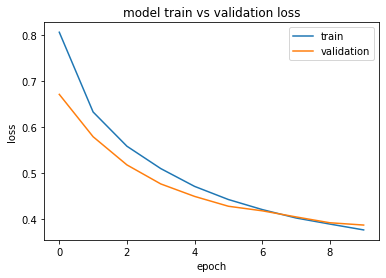

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, lstm_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78     10633
           1       0.90      0.78      0.84      5600
           2       0.84      0.69      0.75      9458
           3       0.94      0.95      0.95     39873
           4       0.86      0.83      0.85     13355

   micro avg       0.90      0.86      0.88     78919
   macro avg       0.87      0.80      0.83     78919
weighted avg       0.90      0.86      0.88     78919
 samples avg       0.86      0.86      0.86     78919



In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

[[ 8857    95   329   709   643]
 [  636  4352   310   173   129]
 [ 1401   118  6487   727   725]
 [ 1110   167   361 37965   270]
 [ 1168    83   247   758 11099]]


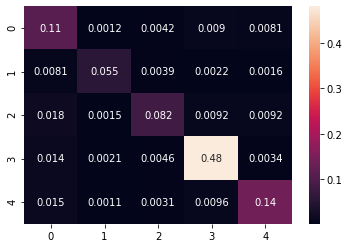

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via 2 Bi-LSTM with Emojis

In [ ]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(maxlen_emoji,))
embed2 = Embedding(emo_vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_emoji_embedding_vectors], input_length=maxlen_emoji, trainable=False)(input2)
bdlstm2 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed2)
dense2 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 200)     26521600    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 200)      229600      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, E_train_tok], y_train_tok, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 276s 1ms/sample - loss: 0.8221 - acc: 0.7039 - val_loss: 0.6587 - val_acc: 0.7647
Epoch 2/6
252538/252538 [==============================] - 271s 1ms/sample - loss: 0.6326 - acc: 0.7739 - val_loss: 0.5665 - val_acc: 0.8010
Epoch 3/6
252538/252538 [==============================] - 272s 1ms/sample - loss: 0.5594 - acc: 0.8011 - val_loss: 0.5107 - val_acc: 0.8222
Epoch 4/6
252538/252538 [==============================] - 271s 1ms/sample - loss: 0.5100 - acc: 0.8198 - val_loss: 0.4696 - val_acc: 0.8400
Epoch 5/6
252538/252538 [==============================] - 268s 1ms/sample - loss: 0.4725 - acc: 0.8342 - val_loss: 0.4429 - val_acc: 0.8504
Epoch 6/6
252538/252538 [==============================] - 269s 1ms/sample - loss: 0.4435 - acc: 0.8459 - val_loss: 0.4231 - val_acc: 0.8593


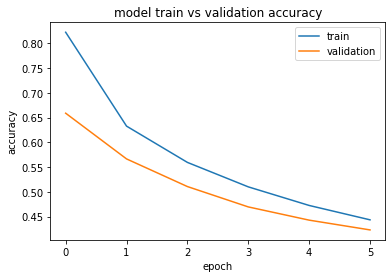

In [ ]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
bilstm_pred = (bilstm_model.predict([X_test_tok, E_test_tok]) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, bilstm_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

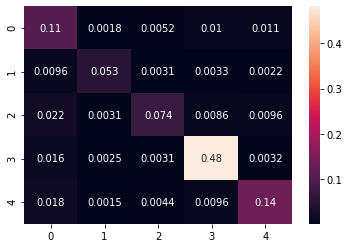

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via Transformer

https://keras.io/examples/nlp/text_classification_with_transformer/

In [ ]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 409.0MB 44kB/s 
     |████████████████████████████████| 4.0MB 52.1MB/s 
     |████████████████████████████████| 5.9MB 25.0MB/s 
     |████████████████████████████████| 4.0MB 43.7MB/s 
     |████████████████████████████████| 471kB 55.5MB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32

In [ ]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token (vs 32 ?)
num_heads = 2  # Number of attention heads 
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(embed_dim, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

transfo_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Train and Evaluate
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
transfo_history = transfo_model.fit(
    X_train_tok, y_train_tok, validation_split=0.2, batch_size=512, epochs=4 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
493/494 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.5442WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff686aa7950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

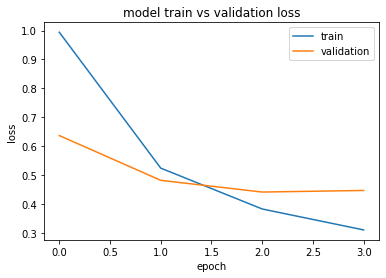

In [ ]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
transfo_pred = (transfo_model.predict(X_test_tok) >= 0.5).astype("int")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(classification_report(y_test_tok, transfo_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     10683
           1       0.79      0.83      0.81      5481
           2       0.81      0.69      0.75      9460
           3       0.96      0.93      0.94     39885
           4       0.83      0.81      0.82     13410

   micro avg       0.89      0.84      0.87     78919
   macro avg       0.84      0.79      0.81     78919
weighted avg       0.89      0.84      0.86     78919
 samples avg       0.84      0.84      0.84     78919



In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9098    90   215   433   781]
 [  870  4024   364   109   125]
 [ 2096   117  6185   502   650]
 [ 1393   177   388 37149   637]
 [ 1797    61   162   606 10890]]


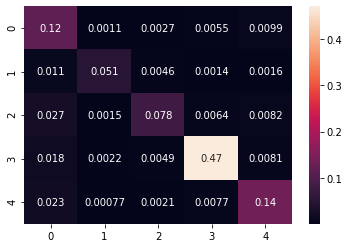

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

### Via CamemBERT

==> https://colab.sandbox.google.com/drive/1KgWs_sYNEL_ZnnZ_p7eTSevVb5xXx1Hu?usp=sharing#scrollTo=ELf3ehrNxY3k

In [74]:
!pip install transformers==3.5.1
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = dataset['cleanSentence'].to_list()
labels = list(encoded_y)

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

     |████████████████████████████████| 1.3MB 6.3MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 2.9MB 27.1MB/s 
     |████████████████████████████████| 1.1MB 35.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aeb2530dd28b18194070acc056e8d9a30cd7c8a88ff70590739bf25521531ddb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


ImportError: ignored

In [ ]:
def preprocess(raw_text, labels=None):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if labels:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Split train-validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(text, labels,
                                                            random_state=42, test_size=0.2)

In [ ]:
train_input_ids, train_attention_mask, train_labels = preprocess(train_inputs, train_labels)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_labels)

val_input_ids, val_attention_mask, validation_labels = preprocess(validation_inputs, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_labels)

In [ ]:
# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("Bert.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Unable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 5)

model.to(device) 

Unable to load trained model.
[Errno 2] No such file or directory: 'Bert.pt'


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
#Training parameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

In [ ]:
# Training & Validation
for epoch in range(0, epochs):
  print("")
  print(f'########## Epoch {epoch+1} / {epochs} ##########')
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t0

        # Report progress
        print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: skills 
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass
    model.zero_grad()        

    # Perform a forward pass (evaluate the model on this training batch)
    # the loss (because we provided skills) and the "logits"--the model
    # outputs prior to activation
    loss, logits = model(input_id, 
                          token_type_ids=None, 
                          attention_mask=attention_mask, 
                          labels=label)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containing a
    # single value; the '.item()' function just returns the Python value 
    # from the tensor
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)   

  if epoch > 0:
      if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
          # i.e. If there is not improvement
          consecutive_epochs_with_no_improve += 1
      else:
          # If there is improvement
          consecutive_epochs_with_no_improve = 0
          print("Model saved!")
          torch.save(model.state_dict(), "Bert.pt")

  # Measure how long this epoch took
  training_time = time.time() - t0

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
  )

  print("epoch: {} \n".format(epoch + 1), file=outfile)
  print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
  print("Training Time: {} \n".format(training_time), file=outfile)

  if consecutive_epochs_with_no_improve == 2:
      print("Stop training : The loss has not changed since 2 epochs!")
      break


  # Tracking variables for validation
  eval_loss, eval_accuracy = 0, 0
  batch_count = 0

  t1 = time.time()
  # Validation of the model
  model.eval()

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      elapsed = time.time() - t1
      print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
      #
      # 'batch' contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: skills 
      input_id = batch[0].to(device)
      attention_mask = batch[1].to(device)
      label = batch[2].to(device)

      with torch.no_grad():
      # Forward pass, calculate logit predictions
          outputs =  model(input_id, token_type_ids=None, 
                            attention_mask=attention_mask,
                            labels=label)
          loss, logits = outputs[:2]

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. 'loss' is a Tensor containing a
      # single value; the '.item()' function just returns the Python value 
      # from the tensor
      eval_loss += loss.item()

      # Move logits and labels to CPU if GPU is used
      logits = logits.detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      predictions = np.argmax(logits, axis=1).flatten()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      if batch_count == 0:
          global_predictions = predictions
      else:
          global_predictions = np.append(global_predictions,predictions)
      batch_count += 1


  avg_validation_loss = eval_loss / len(validation_dataloader)   


  # Measure how long this epoch took
  validation_time = time.time() - t1

  print("")
  print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
  print("  Validation took: {:}".format(validation_time))
  print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
  # Calculate the average loss over all of the batches

  # Record all statistics from this epoch.
  validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
  )

  print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
  print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)

#torch.save(model.state_dict(), "Bert.pt")
#print("Final Model saved!")


########## Epoch 1 / 6 ##########
Training...


AttributeError: ignored

In [ ]:
global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(validation_labels, global_preds, zero_division=0)
print("Report: {} \n".format(report))

confusion_matrix = metrics.confusion_matrix(validation_labels, global_preds)

print("Confusion Matrix: {} \n".format(confusion_matrix))

sns.heatmap(confusion_matrix, annot=True)


## Next stage - Prediction based on sentence + target

### Via Bi-LSTM

In [ ]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
bilstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 150, 200)     26521600    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 256)          336896      embedding_3[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7)]          0                                            
____________________________________________________________________________________________

In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, X_train_targets], y_train_tok, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 228s 904us/sample - loss: 0.5586 - acc: 0.7743 - val_loss: 0.4240 - val_acc: 0.8254
Epoch 2/6
252538/252538 [==============================] - 227s 897us/sample - loss: 0.3927 - acc: 0.8397 - val_loss: 0.3475 - val_acc: 0.8637
Epoch 3/6
252538/252538 [==============================] - 225s 891us/sample - loss: 0.3382 - acc: 0.8647 - val_loss: 0.3071 - val_acc: 0.8826
Epoch 4/6
252538/252538 [==============================] - 222s 880us/sample - loss: 0.3012 - acc: 0.8809 - val_loss: 0.2740 - val_acc: 0.8986
Epoch 5/6
252538/252538 [==============================] - 224s 887us/sample - loss: 0.2745 - acc: 0.8921 - val_loss: 0.2596 - val_acc: 0.9036
Epoch 6/6
252538/252538 [==============================] - 218s 864us/sample - loss: 0.2556 - acc: 0.9003 - val_loss: 0.2484 - val_acc: 0.9091


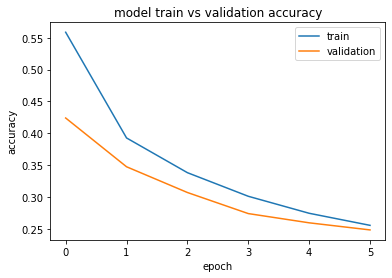

In [ ]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
bilstm_pred = (bilstm_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, bilstm_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10828
           1       0.94      0.81      0.87      5610
           2       0.82      0.73      0.77      9296
           3       1.00      1.00      1.00     39709
           4       0.86      0.84      0.85     13476

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.89      0.83      0.86     78919
weighted avg       0.93      0.89      0.91     78919
 samples avg       0.89      0.89      0.89     78919



In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

[[ 9230    98   620     0   880]
 [  568  4535   333     0   174]
 [ 1592   123  6756     2   823]
 [    3     0     1 39705     0]
 [ 1438    83   573     0 11382]]


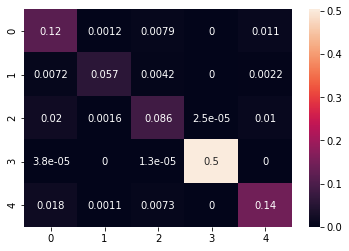

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via Transformer

In [ ]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

input1 = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(input1)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(EMBEDDING_DIM, activation="relu")(x)
dense1 = layers.Dropout(0.1)(x)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
targ_transfo_model = keras.Model(inputs = [input1, input2], outputs = out)
targ_transfo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
targ_transfo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 150, 200)     26521600    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 256)          336896      embedding_3[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7)]          0                                            
____________________________________________________________________________________________

In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

targ_transfo_history = targ_transfo_model.fit([X_train_tok, X_train_targets], y_train_tok, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 228s 904us/sample - loss: 0.5586 - acc: 0.7743 - val_loss: 0.4240 - val_acc: 0.8254
Epoch 2/6
252538/252538 [==============================] - 227s 897us/sample - loss: 0.3927 - acc: 0.8397 - val_loss: 0.3475 - val_acc: 0.8637
Epoch 3/6
252538/252538 [==============================] - 225s 891us/sample - loss: 0.3382 - acc: 0.8647 - val_loss: 0.3071 - val_acc: 0.8826
Epoch 4/6
252538/252538 [==============================] - 222s 880us/sample - loss: 0.3012 - acc: 0.8809 - val_loss: 0.2740 - val_acc: 0.8986
Epoch 5/6
252538/252538 [==============================] - 224s 887us/sample - loss: 0.2745 - acc: 0.8921 - val_loss: 0.2596 - val_acc: 0.9036
Epoch 6/6
252538/252538 [==============================] - 218s 864us/sample - loss: 0.2556 - acc: 0.9003 - val_loss: 0.2484 - val_acc: 0.9091


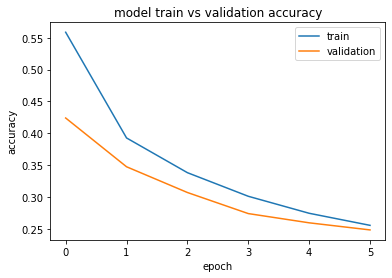

In [ ]:
plt.plot(targ_transfo_history.history['loss'])
plt.plot(targ_transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
targ_transfo_pred = (targ_transfo_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, targ_transfo_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10828
           1       0.94      0.81      0.87      5610
           2       0.82      0.73      0.77      9296
           3       1.00      1.00      1.00     39709
           4       0.86      0.84      0.85     13476

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.89      0.83      0.86     78919
weighted avg       0.93      0.89      0.91     78919
 samples avg       0.89      0.89      0.89     78919



In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), targ_transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9230    98   620     0   880]
 [  568  4535   333     0   174]
 [ 1592   123  6756     2   823]
 [    3     0     1 39705     0]
 [ 1438    83   573     0 11382]]


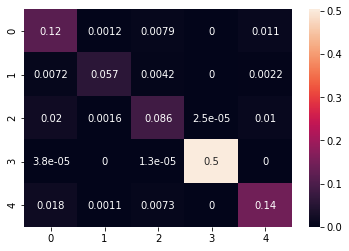

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

### Via CamemBERT

In [219]:
!pip install transformers==3.5.1
!pip install sentencepiece
from transformers import TFCamembertModel, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64

text = dataset['cleanSentence'].to_list()
labels = onehot_y
targets = onehot_targets

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

In [212]:
def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  
  for i in range(len(data)):
      encoded = cam_tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids), np.array(attention_masks)

In [220]:
onehot_targets

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [221]:
# Split train-validation
train_inputs, validation_inputs, train_targets, validation_targets, train_labels, validation_labels = train_test_split(text, targets, labels,
                                                            random_state=42, test_size=0.2)

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_inputs,MAX_LEN)

test_input_ids,test_attention_masks = bert_encode(validation_inputs,MAX_LEN)


In [ ]:
camembert_model = TFCamembertModel.from_pretrained(
        "jplu/tf-camembert-base")
#camembert_model = CamembertForSequenceClassification.from_pretrained(
#        'camembert-base',
#        num_labels = 5)

Some layers from the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [206]:
input_ids = tf.keras.Input(shape=(MAX_LEN,),dtype='int32')
attention_masks = tf.keras.Input(shape=(MAX_LEN,),dtype='int32')

input1 = camembert_model([input_ids, attention_masks])
input1 = input1[1]
input1 = tf.keras.layers.Dense(EMBEDDING_DIM,activation='relu')(input1)
dense1 = tf.keras.layers.Dropout(0.2)(input1)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
targ_bert_model = keras.Model(inputs = [[input_ids, attention_masks], input2], outputs = out)
targ_bert_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [207]:
targ_bert_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_87 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_88 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_camembert_model_4 (TFCamembe ((None, 128, 768), ( 110621952   input_87[0][0]                   
                                                                 input_88[0][0]                   
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 200)          153800      tf_camembert_model_4[1][1]

In [225]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

targ_bert_history = targ_bert_model.fit([[train_input_ids,train_attention_masks], np.array(train_targets)], np.array(train_labels), validation_split=0.2, epochs=6, batch_size = 64, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6


TypeError: ignored

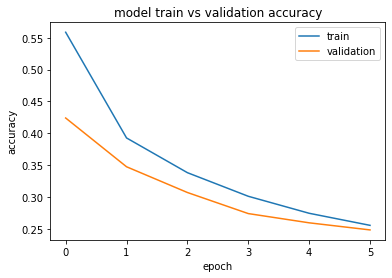

In [ ]:
plt.plot(targ_bert_history.history['loss'])
plt.plot(targ_bert_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
targ_bert_pred = (targ_bert_model.predict([test_input_ids, validation_targets]) >= 0.5).astype("int")

In [ ]:
print(classification_report(validation_targets, targ_bert_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10828
           1       0.94      0.81      0.87      5610
           2       0.82      0.73      0.77      9296
           3       1.00      1.00      1.00     39709
           4       0.86      0.84      0.85     13476

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.89      0.83      0.86     78919
weighted avg       0.93      0.89      0.91     78919
 samples avg       0.89      0.89      0.89     78919



In [ ]:
conf_matrix = confusion_matrix(validation_labels.argmax(axis=1), targ_bert_pred.argmax(axis=1))
print(conf_matrix)

[[ 9230    98   620     0   880]
 [  568  4535   333     0   174]
 [ 1592   123  6756     2   823]
 [    3     0     1 39705     0]
 [ 1438    83   573     0 11382]]


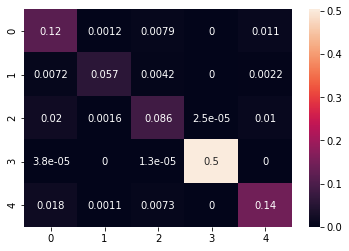

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

# Target prediction

### By training a classifier based on current "Target" label

#### Via Bi-LSTM

In [75]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
#lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(7, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [76]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 200)          26499400  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 200)               51400     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1407      
Total params: 26,889,103
Trainable params: 389,703
Non-trainable params: 26,499,400
_________________________________________________________________


In [78]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, X_train_targets, validation_split=0.2, epochs=6, batch_size =512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
494/494 [==============================] - 436s 872ms/step - loss: 0.6879 - acc: 0.7679 - val_loss: 0.5266 - val_acc: 0.8180
Epoch 2/6
494/494 [==============================] - 429s 868ms/step - loss: 0.4955 - acc: 0.8280 - val_loss: 0.4237 - val_acc: 0.8527
Epoch 3/6
494/494 [==============================] - 428s 867ms/step - loss: 0.4167 - acc: 0.8541 - val_loss: 0.3644 - val_acc: 0.8740
Epoch 4/6
494/494 [==============================] - 426s 863ms/step - loss: 0.3628 - acc: 0.8737 - val_loss: 0.3207 - val_acc: 0.8918
Epoch 5/6
494/494 [==============================] - 425s 860ms/step - loss: 0.3253 - acc: 0.8862 - val_loss: 0.2913 - val_acc: 0.9024
Epoch 6/6
494/494 [==============================] - 427s 864ms/step - loss: 0.2976 - acc: 0.8962 - val_loss: 0.2718 - val_acc: 0.9106


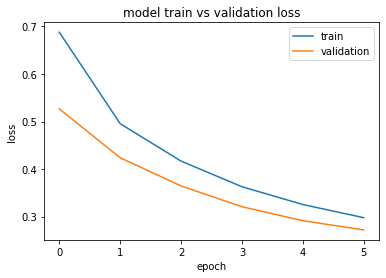

In [79]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [80]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [81]:
print(classification_report(X_test_targets, lstm_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       505
           1       0.96      0.98      0.97      3336
           2       0.93      0.89      0.91      7171
           3       0.87      0.91      0.89      7293
           4       0.93      0.95      0.94     39807
           5       0.91      0.78      0.84     19514
           6       0.90      0.99      0.94      1293

   micro avg       0.92      0.90      0.91     78919
   macro avg       0.92      0.92      0.92     78919
weighted avg       0.92      0.90      0.91     78919
 samples avg       0.90      0.90      0.90     78919



In [82]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

[[  482     0     0     0    23     0     0]
 [   12  3285     0     2    14    23     0]
 [  299     9  6356    83   162   262     0]
 [  165     4    36  6667   170   251     0]
 [  370    49   138   333 37845  1036    36]
 [  584    83   290   605  2579 15273   100]
 [    9     0     0     0     2     7  1275]]


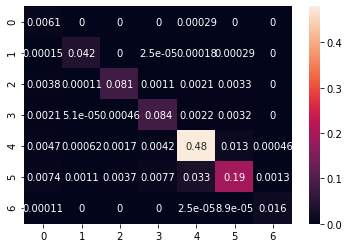

In [83]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

#### Via Transformer

In [ ]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 409.0MB 44kB/s 
     |████████████████████████████████| 4.0MB 52.1MB/s 
     |████████████████████████████████| 5.9MB 25.0MB/s 
     |████████████████████████████████| 4.0MB 43.7MB/s 
     |████████████████████████████████| 471kB 55.5MB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32

In [ ]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token (vs 32 ?)
num_heads = 2  # Number of attention heads 
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(embed_dim, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(7, activation="softmax")(x)

transfo_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Train and Evaluate
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
transfo_history = transfo_model.fit(
    X_train_tok, X_train_targets, validation_split=0.2, batch_size=512, epochs=4 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
493/494 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.5442WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff686aa7950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

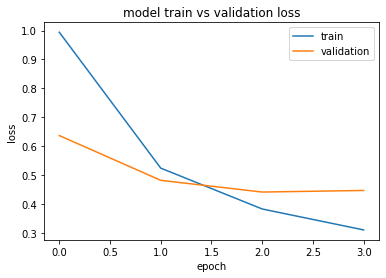

In [ ]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
transfo_pred = (transfo_model.predict(X_test_tok) >= 0.5).astype("int")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(classification_report(X_test_targets, transfo_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     10683
           1       0.79      0.83      0.81      5481
           2       0.81      0.69      0.75      9460
           3       0.96      0.93      0.94     39885
           4       0.83      0.81      0.82     13410

   micro avg       0.89      0.84      0.87     78919
   macro avg       0.84      0.79      0.81     78919
weighted avg       0.89      0.84      0.86     78919
 samples avg       0.84      0.84      0.84     78919



In [ ]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9098    90   215   433   781]
 [  870  4024   364   109   125]
 [ 2096   117  6185   502   650]
 [ 1393   177   388 37149   637]
 [ 1797    61   162   606 10890]]


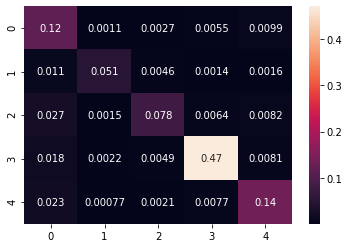

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

### Via lexical features analysis

# Feature analysis

### Sentiment analysis

In [ ]:
!pip install vaderSentiment_fr
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

     |████████████████████████████████| 235kB 5.8MB/s 
     |████████████████████████████████| 245kB 49.0MB/s 
  Created wheel for vaderSentiment-fr: filename=vaderSentiment_fr-1.2-cp37-none-any.whl size=232216 sha256=c232af99699787ebdf86243077aace094bfc6417e1ed82a6e4285f39d98d134d
  Stored in directory: /root/.cache/pip/wheels/a1/3f/c5/0aca890f5c576a804800875e10035a2a0f8bd808952cd82bdf
Successfully built vaderSentiment-fr
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
vader.polarity_scores('Moi mdr t trop nul')

{'compound': 0.4779, 'neg': 0.206, 'neu': 0.345, 'pos': 0.449}

In [ ]:
vader.polarity_scores_max('visage avec des larmes de joie')

visage --> sage
Fuzzy Ratio : 80
Pas pris en compte car < 85
avec --> avare
Fuzzy Ratio : 67
Pas pris en compte car < 85
Processing time : 0.36016273498535156


{'compound': -0.1531, 'neg': 0.264, 'neu': 0.556, 'pos': 0.181}

In [ ]:
def get_vader_sent(val):
  if val >= 0.05:
    return "pos"
  elif val <= -0.05:
    return "neg"
  else:
    return "neu"

In [ ]:
# Checking with non tokenized toxic data
vader_toxic = []
sentiments_toxic = dataset.loc[dataset['Class'] == 1]["cleanSentence"].tolist()

for i in range(len(sentiments_toxic)):
  vader_toxic.append(vader.polarity_scores(str(sentiments_toxic[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_toxic)):
  comp.append(vader_toxic[j]['compound'])
  pos.append(vader_toxic[j]['pos'])
  neg.append(vader_toxic[j]['neg'])
  neu.append(vader_toxic[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.13845125929507032 Positive:  0.06868095460782297 Neutral:  0.7195407851258535 Negative : 0.21178063445240752


In [ ]:
# Checking with non tokenized clean data
vader_clean = []
sentiments_clean = dataset.loc[dataset['Class'] == 0]["cleanSentence"].tolist()

for i in range(len(sentiments_clean)):
  vader_clean.append(vader.polarity_scores(str(sentiments_clean[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_clean)):
  comp.append(vader_clean[j]['compound'])
  pos.append(vader_clean[j]['pos'])
  neg.append(vader_clean[j]['neg'])
  neu.append(vader_clean[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  0.1103306954999951 Positive:  0.1261536849999933 Neutral:  0.8205530599999965 Negative : 0.053292799999998926


In [ ]:
# Checking with non tokenized VERY toxic data
vader_toxic = []
sentiments_toxic = dataset.loc[dataset['Level'] == "HIGH"]["cleanSentence"].tolist()

for i in range(len(sentiments_toxic)):
  vader_toxic.append(vader.polarity_scores(str(sentiments_toxic[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_toxic)):
  comp.append(vader_toxic[j]['compound'])
  pos.append(vader_toxic[j]['pos'])
  neg.append(vader_toxic[j]['neg'])
  neu.append(vader_toxic[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.1677027025000968 Positive:  0.06561415345402831 Neutral:  0.7009890175793817 Negative : 0.23339883428913538


# Error Analysis

### Further dataset inspection

In [88]:
print("\"Nul\" in Low sentences: ", dataset_low["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in High sentences: ", dataset_high["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in Neutral sentences: ", neutral["Sentence"].str.count("nul").sum())

"Nul" in Low sentences:  4786
"Nul" in Medium sentences:  5633
"Nul" in High sentences:  1018
"Nul" in Very_High sentences:  1783
"Nul" in Neutral sentences:  185


In [87]:
print("\"Conne\" in Low sentences: ", dataset_low["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in High sentences: ", dataset_high["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in Neutral sentences: ", neutral["Sentence"].str.count("conne").sum())

"Conne" in Low sentences:  738
"Conne" in Medium sentences:  639
"Conne" in High sentences:  926
"Conne" in Very_High sentences:  1170
"Conne" in Neutral sentences:  754


In [86]:
print("\"Gay\" in Low sentences: ", dataset_low["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in High sentences: ", dataset_high["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in Neutral sentences: ", neutral["Sentence"].str.count("gay").sum())

"Gay" in Low sentences:  290
"Gay" in Medium sentences:  869
"Gay" in High sentences:  2189
"Gay" in Very_High sentences:  1001
"Gay" in Neutral sentences:  97


In [89]:
print("\"Connard\" in Low sentences: ", dataset_low["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in High sentences: ", dataset_high["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in Neutral sentences: ", neutral["Sentence"].str.count("connard").sum())

"Connard" in Low sentences:  51
"Connard" in Medium sentences:  2714
"Connard" in High sentences:  1603
"Connard" in Very_High sentences:  2379
"Connard" in Neutral sentences:  31


In [130]:
#Removing frequent words
#FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
FREQWORDS = ['être', 'ses', 'rien', 'son', 'm', 'juste', 'ont', 'as', 'lui', 'peut', 'aussi', 'dire', 'alors', 'mec', 'car', 'pas', 'ils', 'vraiment', 'même', 'es', 'toi', 'quand', 'ton', 'nous', 'tes', 'ces', 'trop', 'te', 'quoi', 'par', 'n', 'fait', 'vidéo', 'sont', 'ou', 'mon', 'y', 'suis', 'ta', 'ma', 'sa', 'me', 's', 'meme', 'moi', 'vraiment' 'pas', 'je', 'il', 'tu', 'j', 'vous', 'on', 't', 'plus', 'ai', 'se', 'elle', 'faire', 'cette', 'bien', 'de', 'est', 'la', 'et', 'le','les','c','que','des','a','un','en','à', 'pour','qui', 'l', 'd', 'une', 'ce', 'mais', 'qu', 'ne', 'ça', 'dans','du', 'sur', 'avec', 'tout', 'au', 'si', 'comme']

dataset_low_wo_freq = dataset_low.copy()
dataset_medium_wo_freq = dataset_medium.copy()
dataset_high_wo_freq = dataset_high.copy()
dataset_veryhigh_wo_freq = dataset_veryhigh.copy()
neutral_wo_freq = neutral.copy()

neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(lambda x: x.lower())
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_punctuations)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_URL)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_html)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_special)

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

dataset_low_wo_freq['cleanSentence'] = dataset_low_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_medium_wo_freq['cleanSentence'] = dataset_medium_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_high_wo_freq['cleanSentence'] = dataset_high_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_veryhigh_wo_freq['cleanSentence'] = dataset_veryhigh_wo_freq['cleanSentence'].apply(remove_freqwords)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_freqwords)

In [122]:
#Checking frequent words
cnt_low = Counter()
for text in dataset_low_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_low[word] += 1
        
cnt_low.most_common(20)

[('nul', 4196),
 ('merde', 3629),
 ('con', 3115),
 ('gens', 1483),
 ('cons', 1384),
 ('merci', 954),
 ('va', 949),
 ('horrible', 946),
 ('sans', 935),
 ('donc', 935),
 ('bande', 924),
 ('tous', 889),
 ('faut', 859),
 ('dit', 855),
 ('très', 845),
 ('êtes', 838),
 ('peu', 827),
 ('bon', 814),
 ('non', 798),
 ('était', 795)]

In [123]:
#Checking frequent words
cnt_med = Counter()
for text in dataset_medium_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_med[word] += 1
        
cnt_med.most_common(20)

[('nul', 4969),
 ('merde', 2875),
 ('fake', 2298),
 ('va', 2197),
 ('tous', 1990),
 ('gros', 1907),
 ('bande', 1754),
 ('con', 1711),
 ('gens', 1635),
 ('pauvre', 1604),
 ('connard', 1597),
 ('faut', 1442),
 ('leur', 1351),
 ('france', 1303),
 ('non', 1294),
 ('encore', 1272),
 ('sans', 1213),
 ('votre', 1139),
 ('dit', 1130),
 ('êtes', 1129)]

In [124]:
#Checking frequent words
cnt_high = Counter()
for text in dataset_high_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_high[word] += 1
        
cnt_high.most_common(20)

[('merde', 4569),
 ('vos', 4239),
 ('con', 3487),
 ('pd', 3346),
 ('gros', 2678),
 ('bande', 2354),
 ('va', 2135),
 ('tous', 2109),
 ('gay', 1718),
 ('fermer', 1714),
 ('gueule', 1685),
 ('fermez', 1511),
 ('pute', 1501),
 ('leur', 1460),
 ('êtes', 1454),
 ('gens', 1419),
 ('fais', 1339),
 ('gueules', 1314),
 ('faut', 1300),
 ('grosse', 1271)]

In [125]:
#Checking frequent words
cnt_veryhigh = Counter()
for text in dataset_veryhigh_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_veryhigh[word] += 1
        
cnt_veryhigh.most_common(20)

[('merde', 11168),
 ('gueule', 6500),
 ('vos', 5620),
 ('tous', 4282),
 ('tg', 4228),
 ('ferme', 3960),
 ('va', 3958),
 ('bande', 3891),
 ('gens', 3582),
 ('gros', 3483),
 ('allez', 3336),
 ('con', 2942),
 ('fdp', 2815),
 ('mère', 2638),
 ('vie', 2568),
 ('pute', 2557),
 ('leur', 2520),
 ('grosse', 2501),
 ('foutre', 2385),
 ('faut', 2385)]

In [131]:
#Checking frequent words
cnt_neutral = Counter()
for text in neutral_wo_freq["Sentence"].values:
    for word in text.split():
        cnt_neutral[word] += 1
        
cnt_neutral.most_common(20)

[('https', 12176),
 ('co', 10555),
 ('va', 4956),
 ('non', 4729),
 ('merci', 4666),
 ('très', 4209),
 ('oui', 4131),
 ('tous', 3972),
 ('faut', 3884),
 ('1', 3829),
 ('bon', 3795),
 ('2', 3671),
 ('avoir', 3602),
 ('dit', 3350),
 ('sans', 3315),
 ('était', 3255),
 ('gens', 3211),
 ('là', 3185),
 ('bonne', 3174),
 ('donc', 3060)]